In [1]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt

import sys
from paths import Paths
paths = Paths()
sys.path.append(paths.scripts_root)
import util

import imutils

%load_ext autoreload
%autoreload 2

# Display entire width of browser
from IPython.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

paths.print_paths()
sys.path.append(paths.inhouse+'/dif/python')

# from Yesh's DIF_IP script
from pixval import Formatter
import dif_utils as du
from enum import IntEnum

green = (0, 255, 0)

Paths defined in paths module:
 paths.notebook_root: /Users/trafferty/data/notebooks
 paths.tmp_dir: /Users/trafferty/tmp
 paths.ws_dir: /Users/trafferty/workspace
 paths.tmp_root: /Users/trafferty/data/tmp
 paths.mii_home: /Users/trafferty/dev
 paths.scripts_root: /Users/trafferty/data/scripts
 paths.images_root: /Users/trafferty/data/images
 paths.data_root: /Users/trafferty/data
 paths.projects_root: /Users/trafferty/data/projects
 paths.inhouse: /Users/trafferty/dev/src/inhouse
 paths.results_root: /Users/trafferty/data/results


In [13]:
DIF1_ip_config = {
           "rMin": 750,
           "rMax": 1980,
           "pxSize_um": 0.345,
           "nozzSpacing_um": 141.1082,
           "phaseIDs": [1,2,3]
       }

DIF2_ip_config = {
           "rMin": 600,
           "rMax": 2000,
           "pxSize_um": 0.309,
           "nozzSpacing_um": 169.333,
           "phaseIDs": [1]
       }

DIF_Synth_ip_config = {
           "rMin": 500,
           "rMax": 2160,
           "pxSize_um": 0.309,
           "nozzSpacing_um": 131.63,
           "phaseIDs": [1]
}

ip_config = {}

ip_config['timeLapse_us'] = 4    # Time lapse between images for velocity calc
ip_config['pxSize_um'] = 0.345 ;#0.350
# Image crop bounds and sub-sample step size
ip_config['rMin'] = 1028 ;#528 ;#648
ip_config['rMax'] = 2160 ;#2148
ip_config['cMin'] = 0
ip_config['cMax'] = 2560 ;#2548
ip_config['rStep'] = 1
ip_config['cStep'] = 1

# Preprocessing params
ip_config['bg_thresh'] = 30
ip_config['adaptiveMethod'] = cv2.ADAPTIVE_THRESH_GAUSSIAN_C #cv2.ADAPTIVE_THRESH_MEAN_C #cv2.ADAPTIVE_THRESH_GAUSSIAN_C
ip_config['thresholdType'] = cv2.THRESH_BINARY+cv2.THRESH_OTSU#cv2.THRESH_BINARY #cv2.THRESH_BINARY_INV
ip_config['blockSize'] = 25 #odd number like 3,5,7,9,11
ip_config['subConst'] = 2 # constant to be subtracted
ip_config['minThVal'] = 0      # Min and max threshold values
ip_config['maxThVal'] = 255

# Params for pruning blobs by size, circularity
ip_config['circTh'] = 0.7
# Used to filter out images with no drop (hence too many stray objects) and too many drops
ip_config['maxDropsPerImg'] = 200

ip_config["ROI_width_height"] = 150

# Blob registration parameters
ip_config['blobCorrBBXSzPx'] = 101       ;# Correlation bounding box X size (width)
ip_config['blobCorrBBYSzPx'] = 101       ;# Correlation bounding box Y size (height)
ip_config['blobCorrTh'] = 0.95           ;# Blob correlation threshold
ip_config['xDispPxTh'] = 10              ;# Max X displacement in pixels
ip_config['yDispPxTh'] = 150             ;# Max Y displacement in pixels
ip_config['areaDiffTh'] = 100            ;# Max diff in areas of corresponding blobs
ip_config['majorAxisDiffTh'] = 10        ;# Max diff in major axis lengths of corres blobs
ip_config['minorAxisDiffTh'] = 10        ;# Max diff in minor axis lengths of corres blobs

ip_config["minSzInPx"] = 400/(ip_config["rStep"]*ip_config["rStep"])
ip_config["maxSzInPx"] = 1600/(ip_config["rStep"]*ip_config["rStep"])

# Combine the system-specific settings with the defaults (system-specific over-ride defaults)
DIF1_ip_config = {**ip_config, **DIF1_ip_config }
DIF2_ip_config = {**ip_config, **DIF2_ip_config }
DIF_Synth_ip_config = {**ip_config, **DIF_Synth_ip_config }


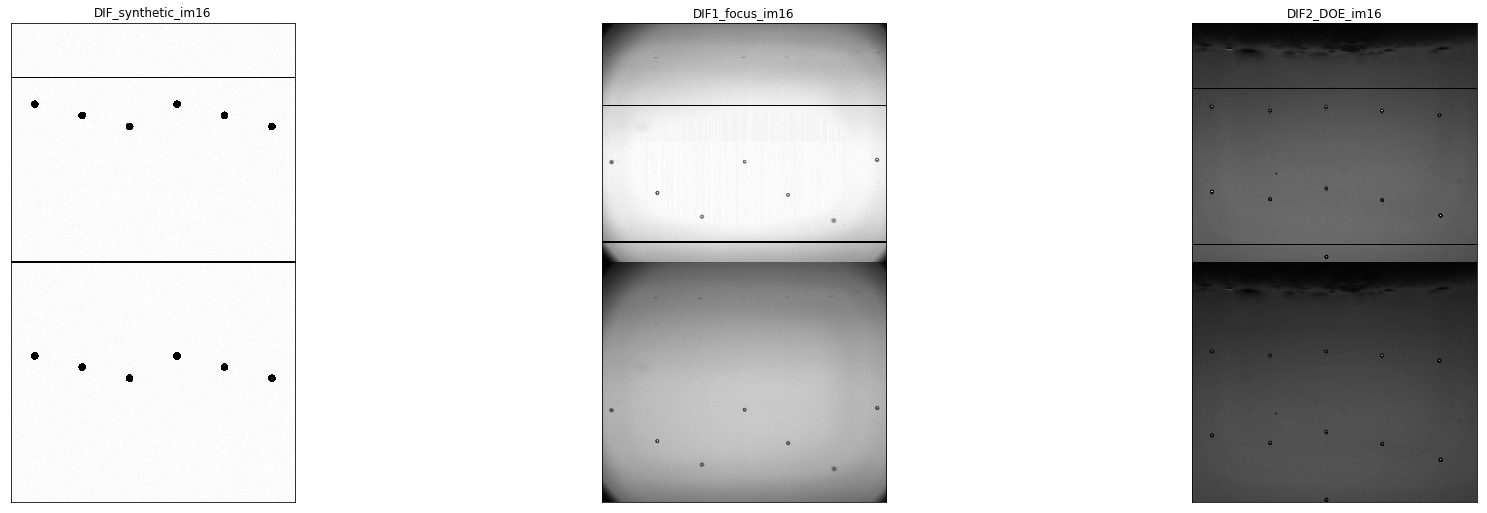

In [14]:
DIF_synthetic_path=paths.tmp_dir+'/DIF/dif_images/DIF_Synthetic_with_proper_metadata.png'
DIF1_focus_path=paths.tmp_dir+'/DIF/dif_images/focus/+0/2017-09-29_09.22.41/DispenserOpt_00006_2017-09-29_09.22.54.png'
DIF2_DOE_path=paths.tmp_dir+'/DIF/DIF2_2018-04-12_12.07.25/DispenserOpt_00001_2018-04-12_12.07.27.png'

DIF_synthetic_im16 = cv2.imread(DIF_synthetic_path, cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
DIF1_focus_im16 = cv2.imread(DIF1_focus_path, cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
DIF2_DOE_im16 = cv2.imread(DIF2_DOE_path, cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)

# add horiz lines for rMin, rMax
cv2.line(DIF_synthetic_im16, (1, DIF_Synth_ip_config["rMin"]), (DIF_synthetic_im16.shape[1], DIF_Synth_ip_config["rMin"]), (255,255,255), 10)
cv2.line(DIF_synthetic_im16, (1, DIF_Synth_ip_config["rMax"]), (DIF_synthetic_im16.shape[1], DIF_Synth_ip_config["rMax"]), (255,255,255), 10)
cv2.line(DIF1_focus_im16, (1, DIF1_ip_config["rMin"]), (DIF1_focus_im16.shape[1], DIF1_ip_config["rMin"]), (255,255,255), 10)
cv2.line(DIF1_focus_im16, (1, DIF1_ip_config["rMax"]), (DIF1_focus_im16.shape[1], DIF1_ip_config["rMax"]), (255,255,255), 10)
cv2.line(DIF2_DOE_im16, (1, DIF2_ip_config["rMin"]), (DIF2_DOE_im16.shape[1], DIF2_ip_config["rMin"]), (255,255,255), 10)
cv2.line(DIF2_DOE_im16, (1, DIF2_ip_config["rMax"]), (DIF2_DOE_im16.shape[1], DIF2_ip_config["rMax"]), (255,255,255), 10)


#imgplot =plt.imshow(im16, cmap='gray')
#plt.colorbar()

util.plot_imgs([(DIF_synthetic_im16, 'DIF_synthetic_im16'), (DIF1_focus_im16, 'DIF1_focus_im16'), (DIF2_DOE_im16, 'DIF2_DOE_im16')], max_cols = 3)

In [4]:
DIF_sythetic_metadata = du.getMetadata(DIF_synthetic_path)
       
'''
As of 05/01/2018, the metadata should have the following fields:

Keys in both:
'''
metadata_05_01_2018_fields = ['PD_start_us', 'PD_delay_us', 'qsw2_start_us', 'drop_pattern_gap_us', 'git-sha', 'double_shutter', 'qsw1_start_us', 'ExperimentID', 
                              'DispenseBitmapFile', 'Location', 'ImageID', 'lamp1_start_us', 'Camera', 'HeadSerialNumber', 'cam1_int_start_us', 'MonomerID', 
                              'Waveform', 'start_time_us', 'lamp2_start_us', 'git-branch', 'Magnification', 'cam3_int_start_us', 'double_shutter_delay_us', 
                              'drop_latency_us', 'Nozzle', 'DIF_Version', 'cam2_int_start_us', 'NozzleID', 'cycle_time_us', 'Phase', 'Row', 'Loop_Count', 
                              'Total_Loops', 'ExperimentType', 'SecondaryNozzles', 'PrimaryNozzles', 'HeadName', 'Mean_Time_per_Loop', 'Est_Completion_Time', 
                              'ExperimentIndex', 'Run_Mode', 'Sample_Clock', 'Global_Voltage', 'Elapsed_Time', 'elapsed_ms', 'ImageFile', 'ExpFolder']

'''
...broken down into the following categories:
'''    

exp_fields = [ 
 'git-sha', 'git-branch','double_shutter', 'ExperimentID','Location', 'Camera', 'HeadSerialNumber', 
 'MonomerID', 'Magnification', 'SecondaryNozzles', 'PrimaryNozzles', 'HeadName', 'ExpFolder', 'DIF_Version']

loop_fields = ['PD_delay_us',  'DispenseBitmapFile',  'ImageID',  'Waveform', 'double_shutter_delay_us',  
 'Nozzle', 'NozzleID', 'Phase', 'Row', 'Loop_Count', 'Total_Loops', 'ExperimentType', 'ExperimentIndex']

DIF_Server_fields = [ 'ImageFile', 'Mean_Time_per_Loop', 'Est_Completion_Time', 'Run_Mode', 'Elapsed_Time', 'elapsed_ms']

xaar_fields = ['Sample_Clock', 'Global_Voltage']
 
timing_fields = ['PD_start_us', 'qsw2_start_us', 'drop_pattern_gap_us', 'qsw1_start_us', 'lamp1_start_us', 'drop_latency_us',
 'cam1_int_start_us', 'start_time_us', 'lamp2_start_us', 'cam3_int_start_us', 'cam2_int_start_us', 'cycle_time_us',]

all_fields = exp_fields + loop_fields + DIF_Server_fields + xaar_fields + timing_fields 

required_fields = exp_fields + loop_fields

#print(all_fields)

# first let's make sure all_fields is made up of all of metadata_05_01_2018_fields:
for k in metadata_05_01_2018_fields:
    if k not in all_fields:
        print("all_fields missing: ", k)

# Ok, now see if synth img has any fields that are not in all_fields
for k in DIF_sythetic_metadata.keys():
    if k not in all_fields:
        print("synth has field not in all_fields: ", k)
        
# And, most important, are there any missing required fields
for k in required_fields:
    if k not in DIF_sythetic_metadata:
        print("synth missing required field: ", k)


In [5]:
DIF1_focus_metadata_dict = du.getMetadata(DIF1_focus_path)
DIF2_metadata_dict = du.getMetadata(DIF2_DOE_path)

# For our test processing images (focus and DIF2), see what fields they are missing
for k in required_fields:
    if k not in DIF1_focus_metadata_dict:
        print("focus missing required field: %s setting to %s"% (k, DIF_sythetic_metadata[k]) )
        DIF1_focus_metadata_dict[k] = DIF_sythetic_metadata[k]
for k in required_fields:
    if k not in DIF2_metadata_dict:
        print("DIF2 missing required field: %s setting to %s"% (k, DIF_sythetic_metadata[k]) )
        DIF2_metadata_dict[k] = DIF_sythetic_metadata[k]

# then tweak them if necessary:
DIF1_focus_metadata_dict["PrimaryNozzles"] = "3,0,6"
DIF1_focus_metadata_dict["SecondaryNozzles"] = "1,2,4,5"

DIF2_metadata_dict["PrimaryNozzles"] = "2,0,1,3,4"
DIF2_metadata_dict["SecondaryNozzles"] = ""
DIF2_metadata_dict["HeadName"] = "OceF1Chip"
DIF2_metadata_dict["Location"] = "DIF2 Station"

print(DIF1_focus_metadata_dict)

focus missing required field: SecondaryNozzles setting to 1,2,4,5
focus missing required field: PrimaryNozzles setting to 3,0
focus missing required field: HeadName setting to Xaar100x
focus missing required field: ExpFolder setting to /media/DIF_DATA/images/Rel_Test_2018-05-01_16.30.25
focus missing required field: ExperimentType setting to DispenseOpt
focus missing required field: ExperimentIndex setting to 0
DIF2 missing required field: git-sha setting to ce5787839b30ec51a7671e4c465a284793ceb1c1
DIF2 missing required field: git-branch setting to dif_branch
DIF2 missing required field: Location setting to DIF Station
DIF2 missing required field: Camera setting to Andor
DIF2 missing required field: Magnification setting to 20x
DIF2 missing required field: SecondaryNozzles setting to 1,2,4,5
DIF2 missing required field: HeadName setting to Xaar100x
DIF2 missing required field: ExpFolder setting to /media/DIF_DATA/images/Rel_Test_2018-05-01_16.30.25
DIF2 missing required field: DIF_Vers

In [ ]:

test_keypoint = du.KEYPOINT(pt=[0.9, 5.6], size=8.3)


def findBLOBs(img, minArea, maxArea):
    # Setup SimpleBlobDetector parameters.
    params = cv2.SimpleBlobDetector_Params()

    # Change thresholds
    params.minThreshold = 100;
    params.maxThreshold = 150;
#     params.minThreshold = 8
#     params.maxThreshold = 255
    params.minThreshold = 100;
    params.maxThreshold = 200;

    # Filter by Circularity
    params.filterByCircularity = False
    params.minCircularity = .1

    # # Filter by Convexity
    params.filterByConvexity = False
    # params.minConvexity = 0.87

    # # Filter by Inertia
    params.filterByInertia = False
    # params.minInertiaRatio = 0.9

    params.filterByColor = False
    params.blobColor = 0
    
    params.filterByArea = True
#     params.minArea = 4 * np.pi
#     params.maxArea = 100 * np.pi
#     params.minArea = 20    Used for Focus notebook...
#     params.maxArea = 500   Used for Focus notebook...
    params.minArea = minArea
    params.maxArea = maxArea

    detector = cv2.SimpleBlobDetector_create(params)

    # Detect blobs.
    keypoints = detector.detect(img)
    return keypoints

def findDrop1(img8, minArea, maxArea, tag="", debug=True):
    plot_list = []
    plot_list.append( (img8,'roi:%s'%tag) )
    
    keypoints = findBLOBs(img8, minArea, maxArea)
    if debug: print( "[findROI] num keypoints found: ", len(keypoints))

    if len(keypoints):
        max_size = 0
        index_of_max_size = -1
        for idx, kp in enumerate(keypoints):
            x, y, dia = int(kp.pt[0]), int(kp.pt[1]), int(kp.size)
            if debug: print("[findROI] (%d, %d), dia: %d, area: %f" % (x, y, dia, np.pi*dia))
            if kp.size > max_size:
                max_size = kp.size
                index_of_max_size = idx

            if debug:
    #             plot_list.append( (roi,'roi:%s'%tag) )
                cv2.putText(img8, str(idx), (x, y), cv2.FONT_HERSHEY_DUPLEX, 2, (0,0,25), 3)
                cv2.circle(img8, (x, y), int(dia/2), (0,0,25),2)
                cv2.line(img8, (x, y-dia), (x, y+dia), (0,0,25), 3)
                cv2.line(img8, (x-dia, y), (x+dia, y), (0,0,25), 3)
                #plot_list.append( (col_img,'Keypoints') )
                
        index_of_max_size = 0
                
        if debug:
            util.plot_imgs(plot_list)
        return True, keypoints[index_of_max_size]

#         kp = keypoints[index_of_max_size]
#         x, y, dia = int(kp.pt[0]), int(kp.pt[1]), int(kp.size)
#         roi = img8.copy()[y-int(roi_width/2):y+int(roi_width/2), 1:col_width]

#         if debug:
# #             plot_list.append( (roi,'roi:%s'%tag) )
#             cv2.circle(img8, (x, y), int(dia/2), (0,0,255),2)
#             cv2.line(img8, (x, y-dia), (x, y+dia), (0,0,255), 3)
#             cv2.line(img8, (x-dia, y), (x+dia, y), (0,0,255), 3)
#             #plot_list.append( (col_img,'Keypoints') )
#         #cv2.rectangle(img8, (sx, sy), (sx+w, sy+h), (0,0,0), 10) # two corners: (startX, startY), (endX, endY)                

    
#     if len(keypoints):
#         return True, roi
    else:
        return False, None
    
def findDrop2(img8, ip_config, debug=False):
    if debug:
        plot_list = []
        plot_list.append( (img8,'roi:%s'%tag) )

    found = False
    keypoint = None
    
    iRef_th = du.simplePreProcAndBinarize(img8)

    # Find, label and size up the blobs
    labelArrRef = measure.label(iRef_th)
    RegPropsRef = measure.regionprops(labelArrRef)
    numBlobsRef = len(RegPropsRef)
    blobCentroidsRef = np.array([RegPropsRef[i].centroid for i in range(numBlobsRef)])

    # Blob centroids after particle filter
    FiltIdxRef, numGoodBlobsRef = du.pruneBlobs(RegPropsRef, circTh, minSzInPx, maxSzInPx)

    if (numGoodBlobsRef <= 0 or numGoodBlobsRef > maxDropsPerImg):
        print("Bad reference image - %d drops detected" % (numGoodBlobsRef))
    else:
        if debug: print("numGoodBlobsRef: %d" % (numGoodBlobsRef))
        FiltIdxRef = FiltIdxRef[0:numGoodBlobsRef]
        blobCentFiltRef = blobCentroidsRef[FiltIdxRef[0:numGoodBlobsRef]]
        RegPropsRefFilt = [RegPropsRef[i] for i in FiltIdxRef[0:numGoodBlobsRef]]
        
        max_size = 0
        index_of_max_size = -1
        for idx, RegProp in enumerate(RegPropsRefFilt):
            #x, y, dia = int(RegProp.centroid[0]), int(RegProp.centroid[1]), int(RegProp.equivalent_diameter)
  
            y, x = RegProp.centroid
            dia = RegProp.equivalent_diameter
                        
            if debug: print("RegProp.orientation: ", RegProp.orientation)
            if debug: print("RegProp.filled_area: ", RegProp.filled_area)
            if debug: print("RegProp.area: ", RegProp.area)
            if debug: print("Calculated area: ", (np.pi*(RegProp.equivalent_diameter/2.0)*(RegProp.equivalent_diameter/2.0)))
            
            if debug: print("[findROI] (%d, %d), dia: %d, area: %f" % (x, y, dia, np.pi*dia))
            if dia > max_size:
                max_size = dia
                index_of_max_size = idx

#             if debug:
#                 cv2.putText(img8, str(idx), (x, y), cv2.FONT_HERSHEY_DUPLEX, 2, (0,0,25), 3)
#                 cv2.circle(img8, (x, y), int(dia/2), (0,0,25),2)
#                 cv2.line(img8, (x, y-dia), (x, y+dia), (0,0,25), 3)
#                 cv2.line(img8, (x-dia, y), (x+dia, y), (0,0,25), 3)

        found = True
        y, x = RegPropsRefFilt[0].centroid
        dia = RegPropsRefFilt[0].equivalent_diameter

        keypoint = du.KEYPOINT(pt=[x,y], size=dia)
    
    if debug:
        util.plot_imgs(plot_list)

    return found, keypoint

def findDropROIs(img, nozzle_col_lst, ip_config, debug=False):
    drop_roi_lst = []

    if img.dtype != 'uint8':
        img = du.convert16BitTo8Bit(img)
        
    for idx, nozzle_col_roi in enumerate(nozzle_col_lst):
        if debug: print("findDropROIs: Processing nozzle col %d"%idx)
        noz_col_img = sliceIMG(img, nozzle_col_roi)
        found, kp = findDrop(noz_col_img, ip_config, debug=False)
        if found:
            x, y, dia = int(kp.pt[0]), int(kp.pt[1]), int(kp.size)
            if debug: print("findDropROIs: [%d] Dia=%d" % (idx, dia))

            # correct x,y for original image coords
            x += nozzle_col_roi.startX
            y += nozzle_col_roi.startY
            
            roi_width = ip_config["ROI_width_height"]
            drop_roi_lst.append( ROI(startY=y-int(roi_width/2), endY=y+int(roi_width/2), startX=x-int(roi_width/2), endX=x+int(roi_width/2)) )
        else:
            if debug: print("findDropROIs: no drops found")

    return drop_roi_lst


num_cols:  7
coi:  3
col_width:  365
findDropROIs: Processing nozzle col 0
numGoodBlobsRef: 1
RegProp.orientation:  0.35976076113630606
Calculated area:  755.0
findDrop: Stats for 0 of 1:
  (86, 510), dia: 31, area: 97.404362
  RegProp.orientation        : 0.360
  RegProp.eccentricity       : 0.253
  RegProp.equivalent_diameter: 31.005
  RegProp.minor_axis_length  : 38.264
  RegProp.major_axis_length  : 39.554
  RegProp.perimeter          : 176.610
  Calculated area            : 755.000
-----------------------------------------------------
findDropROIs: [0] Dia=31
findDropROIs: Processing nozzle col 1
numGoodBlobsRef: 1
RegProp.orientation:  0.2591967991852996
Calculated area:  917.9999999999998
findDrop: Stats for 0 of 1:
  (132, 788), dia: 34, area: 107.405439
  RegProp.orientation        : 0.259
  RegProp.eccentricity       : 0.317
  RegProp.equivalent_diameter: 34.188
  RegProp.minor_axis_length  : 37.060
  RegProp.major_axis_length  : 39.073
  RegProp.perimeter          : 160.024


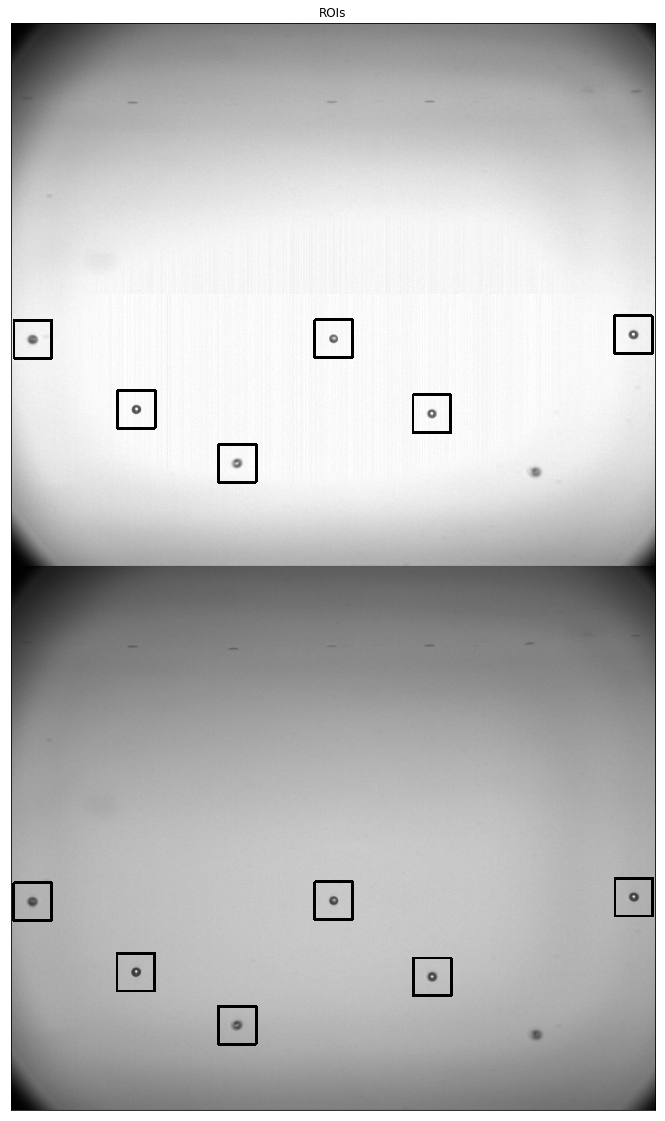

In [183]:
test_data = [ (DIF_synthetic_path, DIF_sythetic_metadata, DIF_Synth_ip_config),
              (DIF1_focus_path, DIF1_focus_metadata_dict, DIF1_ip_config),
              (DIF2_DOE_path, DIF2_metadata_dict, DIF2_ip_config)]
test_idx = 1
debug=True

img_path = test_data[test_idx][0]
metadata_dict = test_data[test_idx][1]
ip_config = test_data[test_idx][2]

ip_config["timeLapse_us"] =  metadata_dict['double_shutter_delay_us']

im16 = cv2.imread(img_path, cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)

top_nozzle_col_ROI_lst, bot_nozzle_col_ROI_lst = du.calcNozzleColROIs(im16, metadata_dict, ip_config, debug=debug)

top_drop_roi_lst = du.findDropROIs(im16, top_nozzle_col_ROI_lst, ip_config, debug=debug)
bot_drop_roi_lst = du.findDropROIs(im16, bot_nozzle_col_ROI_lst, ip_config, debug=debug)

top_drop_stat_lst = []
bot_drop_stat_lst = []

primary_nozzles = [int(x) for x in metadata_dict["PrimaryNozzles"].replace(',', ' ').split()]
secondary_nozzles = [int(x) for x in metadata_dict["SecondaryNozzles"].replace(',', ' ').split()]

img_out = im16.copy()

plot_list = []
for idx, drop_roi in enumerate(top_drop_roi_lst):
    drop_roi_img = du.sliceIMG(im16, drop_roi)
    cv2.rectangle(img_out, (drop_roi.startX,drop_roi.startY), (drop_roi.endX, drop_roi.endY), (255, 0, 255), 10)    # upper-left and lower-right corners (X, Y)
    #plot_list.append((drop_roi_img, "Top-%d"%idx))
    
    drop_stat = {}
    drop_stat["ROI"] = drop_roi
    drop_stat["x"] = drop_roi.cp_x
    drop_stat["y"] = drop_roi.cp_x
    
    drop_stat["primary"] = True if idx in primary_nozzles else False
    drop_stat["NOI"] = True if idx == primary_nozzles[0] else False
    
    top_drop_stat_lst.append(drop_stat)
    
    
for idx, drop_roi in enumerate(bot_drop_roi_lst):
    drop_roi_img = du.sliceIMG(im16, drop_roi)
    cv2.rectangle(img_out, (drop_roi.startX,drop_roi.startY), (drop_roi.endX, drop_roi.endY), (255, 0, 255), 10)    # upper-left and lower-right corners (X, Y)
    #plot_list.append((drop_roi_img, "Top-%d"%idx))

    drop_stat = {}
    drop_stat["ROI"] = drop_roi
    drop_stat["x"] = drop_roi.cp_x
    drop_stat["y"] = drop_roi.cp_x
    bot_drop_stat_lst.append(drop_stat)

plot_list.append((img_out, "ROIs"))
util.plot_imgs(plot_list, max_cols = 1, fig_size = 20)

col 0: 0002795469
col 1: 0004938167
col 2: 0003913864
col 3: 0004807123
col 4: 0005178628
col 5: 0002913685
col 6: 0002795469
col 7: 0004938167
col 8: 0003913864
col 9: 0004807123
col 10: 0005178628
col 11: 0002913685


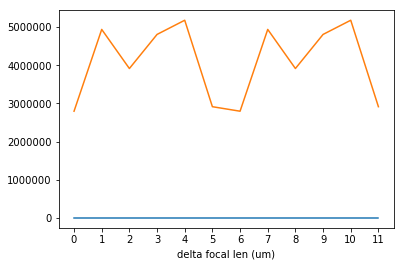

Rank: 0 -> col 4: 0005178628
Rank: 1 -> col 10: 0005178628
Rank: 2 -> col 1: 0004938167
Rank: 3 -> col 7: 0004938167
Rank: 4 -> col 3: 0004807123
Rank: 5 -> col 9: 0004807123
Rank: 6 -> col 2: 0003913864
Rank: 7 -> col 8: 0003913864
Rank: 8 -> col 5: 0002913685
Rank: 9 -> col 11: 0002913685
Rank: 10 -> col 0: 0002795469
Rank: 11 -> col 6: 0002795469


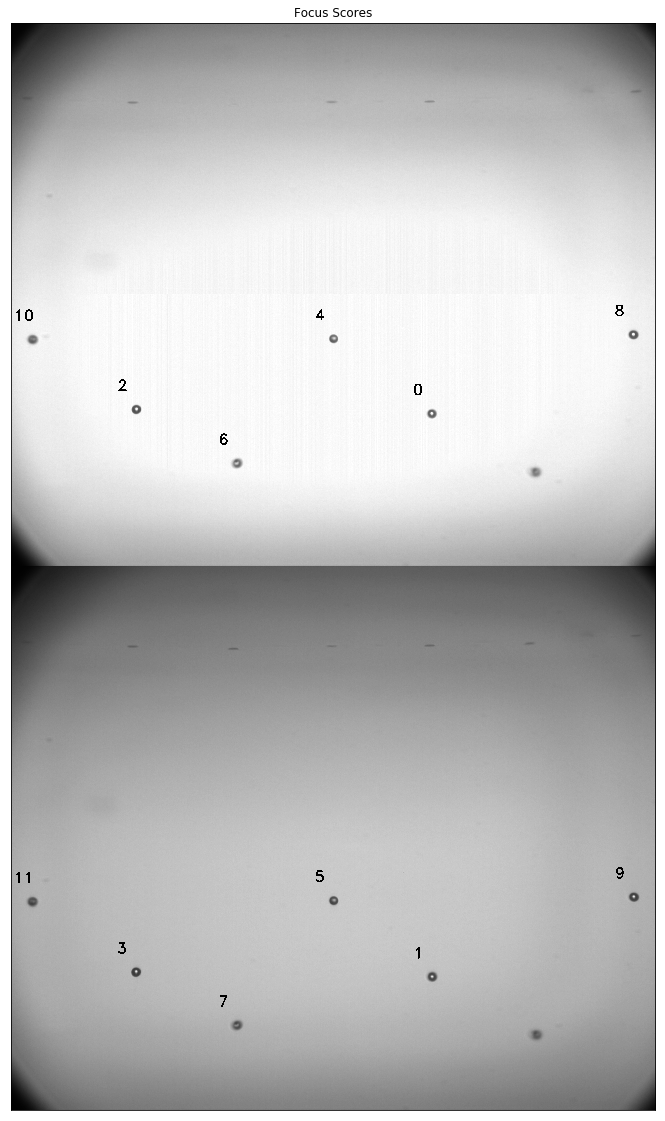

In [185]:
results = []
plot_list = []
ksize=7

#top_and_bot_roi_lst = top_drop_roi_lst+bot_drop_roi_lst
top_and_bot_drop_stat_lst = top_drop_stat_lst+top_drop_stat_lst

#for idx, drop_roi in enumerate(top_and_bot_roi_lst):
for idx, drop_stat in enumerate(top_and_bot_drop_stat_lst):
    drop_roi = drop_stat["ROI"]
    
    drop_roi_img = du.sliceIMG(im16, drop_roi)
    
#     # Calc Laplacian of image
#     lap_img = cv2.Laplacian(drop_roi_img, cv2.CV_64F, ksize=ksize)
#     # Cal variance of Laplacian
#     focus_measure = lap_img.var()
    
    focus_measure = du.variance_of_laplacian(drop_roi_img)
    
    drop_stat["focus_measure"] = focus_measure
    
    #plot_list.append( ((lap_img), "%d: %d" % (idx, int(focus_measure)) ) )
    results.append( (idx, int(focus_measure)) )
    print("col %d: %010d" % (idx, int(focus_measure)))

plt.plot(results)
x_labels = [i[0] for i in results]
plt.xticks(range(len(x_labels)), x_labels)
plt.xlabel('delta focal len (um)')
plt.show()

results_sorted = sorted(results, key=lambda x: x[1], reverse=True)

im2 = im16.copy()
for idx, result in enumerate(results_sorted):
    col = result[0]
    focus_measure = result[1]
    print("Rank: %d -> col %d: %010d" % (idx, col, focus_measure))
    drop_roi = top_and_bot_roi_lst[col]
    cv2.putText(im2, str(idx), (drop_roi.startX, drop_roi.startY), cv2.FONT_HERSHEY_DUPLEX, 2, (0,0,25), 3)

plot_list.append((im2, "Focus Scores"))
util.plot_imgs(plot_list, max_cols = 1, fig_size = 20)


In [186]:
from skimage import feature
from skimage import measure
from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks, hough_ellipse
from skimage.feature import canny
from skimage.draw import circle_perimeter, ellipse_perimeter
from skimage.util import img_as_ubyte

Min: 1030, Max: 41950, Mean: 5267
Min: 0, Max: 45156, Mean: 3182
Min: 0, Max: 40345, Mean: 3316
Min: 0, Max: 41081, Mean: 2857
Min: 0, Max: 41657, Mean: 3003
Min: 77, Max: 43403, Mean: 4767
Min: 1030, Max: 41950, Mean: 5267
Min: 0, Max: 45156, Mean: 3182
Min: 0, Max: 40345, Mean: 3316
Min: 0, Max: 41081, Mean: 2857
Min: 0, Max: 41657, Mean: 3003
Min: 77, Max: 43403, Mean: 4767


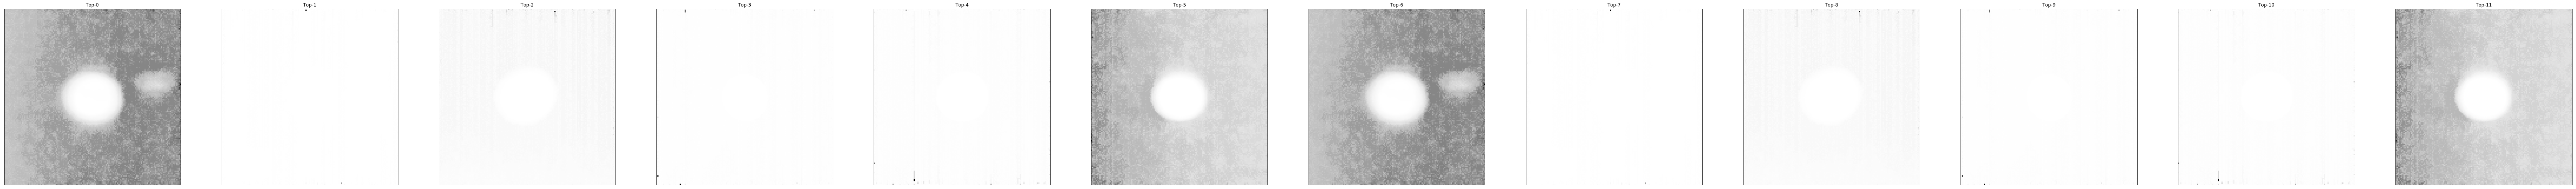

In [187]:
from skimage.morphology import reconstruction
from skimage import exposure
from skimage.restoration import denoise_bilateral

plot_list = []

#top_and_bot_roi_lst = top_drop_roi_lst+bot_drop_roi_lst
top_and_bot_drop_stat_lst = top_drop_stat_lst+top_drop_stat_lst

#for idx, drop_roi in enumerate(top_and_bot_roi_lst):
for idx, drop_stat in enumerate(top_and_bot_drop_stat_lst):
    drop_roi = drop_stat["ROI"]

    drop_roi_img = du.sliceIMG(im16, drop_roi)
    
    #drop_roi_img = exposure.rescale_intensity(drop_roi_img)
    
    drop_roi_img_inverted = cv2.bitwise_not(drop_roi_img)

    print("Min: %d, Max: %d, Mean: %d" % (drop_roi_img_inverted.min(), drop_roi_img_inverted.max(), drop_roi_img_inverted.mean()))

    seed = np.copy(drop_roi_img_inverted)
    seed[2:-2, 2:-2] = drop_roi_img_inverted.max()
    mask = drop_roi_img_inverted

    #filled = reconstruction(seed, mask, method='erosion')
    filled = reconstruction(seed, mask, method='erosion')
    
    #denoised = denoise_bilateral(filled, win_size=None, multichannel=False)
    
    #denoised = filled - drop_roi_img
    
    plot_list.append((cv2.bitwise_not(filled), "Top-%d"%idx))

util.plot_imgs(plot_list, max_cols = len(plot_list))

In [188]:
from skimage.filters import threshold_otsu
from skimage.feature import blob_dog, blob_log, blob_doh

plot_list = []

#top_and_bot_roi_lst = top_drop_roi_lst+bot_drop_roi_lst
top_and_bot_drop_stat_lst = top_drop_stat_lst+top_drop_stat_lst

#for idx, drop_roi in enumerate(top_and_bot_roi_lst):
for idx, drop_stat in enumerate(top_and_bot_drop_stat_lst):
    drop_roi = drop_stat["ROI"]

    drop_roi_img = du.sliceIMG(im16, drop_roi)
    
    drop_roi_img_inverted = cv2.bitwise_not(drop_roi_img)

    seed = np.copy(drop_roi_img_inverted)
    seed[20:-20, 20:-20] = drop_roi_img_inverted.max()
    mask = drop_roi_img_inverted

    filled = reconstruction(seed, mask, method='erosion')

    thresh = threshold_otsu(filled)
    binary = np.array(filled > thresh)
    
    drop_stat["num_filled"] = binary.sum()
    
    print("num_filled: ", drop_stat["num_filled"])

    pxSize_um = ip_config['pxSize_um']
    print("pxSize_um: ", pxSize_um)

    effPxSize_um = pxSize_um*ip_config['rStep']*ip_config['cStep']
    print("effPxSize_um: ", effPxSize_um)

    dropArea_squm = drop_stat["num_filled"]*effPxSize_um*effPxSize_um
    dropVol_pL = 1e-3*4*np.pi*pow(pow(dropArea_squm/np.pi,0.5),3)/3
    print("dropArea_squm: ", dropArea_squm)
    print("dropVol_pL: ", dropVol_pL)
    print("focus_measure", (drop_stat["focus_measure"]/1e3))
    print("primary?", drop_stat["primary"])
    print("NOI?", drop_stat["NOI"])
    print("----------------------------------")

    drop_stat["dropVol_pL"] = dropVol_pL
    
#     output = drop_roi_img.copy()
#     green = (200, 255, 200)
#     cv2.putText(output, "dropVol_pL: %f" % dropVol_pL, (10, 10), cv2.FONT_HERSHEY_PLAIN, 1, green, 1)

    
    
    
    if 0:
        binary = exposure.rescale_intensity(binary)
        print("Min: %d, Max: %d, Mean: %d" % (binary.min(), binary.max(), binary.mean()))



        #canny_img = feature.canny(drop_roi_img, sigma=1.0, low_threshold=None, high_threshold=None, mask=None, use_quantiles=False)
        #canny_img = feature.canny(drop_roi_img, sigma=5, low_threshold=None, high_threshold=10) # works for DIF1 images
        canny_img = feature.canny(binary, sigma=5, low_threshold=None, high_threshold=None)  # works for DIF2 images (lower contrast)


        output = binary.copy()

        if False:
            # Detect two radii
            hough_radii = np.arange(10, 50, 1)
            hough_res = hough_circle(canny_img, hough_radii)

            # Select the most prominent 5 circles
            accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,
                                                       total_num_peaks=1)

            print(radii)

            for center_y, center_x, radius in zip(cy, cx, radii):
                circy, circx = circle_perimeter(center_y, center_x, radius)
                output[circy, circx] = (20000)
        else:

            result = hough_ellipse(canny_img, threshold=8)
            #result : ndarray with fields [(accumulator, y0, x0, a, b, orientation)]
            print(result[0].tolist())

            # ellipse_perimeter(r, c, r_radius, c_radius, orientation=0, shape=None)
            rr, cc = ellipse_perimeter(int(result[0][1]), int(result[0][2]), int(result[0][3]), int(result[0][4]), int(result[0][5]))
            output[rr, cc] = (20000)
        
#     plot_list.append((output, "Top-%d"%idx))

    
    
#     alpha = 0.8
#     output = cv2.addWeighted(drop_roi_img_inverted, alpha, binary, 1 - alpha, 0)
    

#     blobs_log = blob_log(binary, max_sigma=15, num_sigma=10, threshold=.1)
#     y, x, r = blobs_log[0]
#     print(blobs_log)
#     overlay = drop_roi_img.copy()
#     #cv2.circle(overlay, (y,x), r, (0,0,255), -1)
    
    #plot_list.append((canny_img, "Top-%d"%idx))
    #plot_list.append((drop_roi_img, "Top-%d"%idx))

util.plot_imgs(plot_list, max_cols = 2)

num_filled:  1231
pxSize_um:  0.345
effPxSize_um:  0.345
dropArea_squm:  146.519775
dropVol_pL:  1.33416076533
focus_measure 2795.4692822
primary? True
NOI? False
----------------------------------
num_filled:  1077
pxSize_um:  0.345
effPxSize_um:  0.345
dropArea_squm:  128.189925
dropVol_pL:  1.0918038978
focus_measure 4938.16799704
primary? False
NOI? False
----------------------------------
num_filled:  1179
pxSize_um:  0.345
effPxSize_um:  0.345
dropArea_squm:  140.330475
dropVol_pL:  1.25052331474
focus_measure 3913.8641158
primary? False
NOI? False
----------------------------------
num_filled:  946
pxSize_um:  0.345
effPxSize_um:  0.345
dropArea_squm:  112.59765
dropVol_pL:  0.898789085885
focus_measure 4807.12335549
primary? True
NOI? True
----------------------------------
num_filled:  1031
pxSize_um:  0.345
effPxSize_um:  0.345
dropArea_squm:  122.714775
dropVol_pL:  1.02260775855
focus_measure 5178.62884603
primary? False
NOI? False
----------------------------------
num_fil

In [ ]:

plot_list = []

top_and_bot_roi_lst = top_drop_roi_lst+bot_drop_roi_lst

for idx, drop_roi in enumerate(top_drop_roi_lst):
    drop_roi_img = sliceIMG(im16, drop_roi)
    edges = feature.canny(drop_roi_img, sigma=5, low_threshold=None, high_threshold=10)
    # Detect two radii
    hough_radii = np.arange(8, 35, 1)
    hough_res = hough_circle(edges, hough_radii)
    
    # Select the most prominent 5 circles
    accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,
                                               total_num_peaks=1)

    print(radii)
    
    # Draw them
    drop_roi_img2 = drop_roi_img.copy()
    for center_y, center_x, radius in zip(cy, cx, radii):
        circy, circx = circle_perimeter(center_y, center_x, radius)
        drop_roi_img2[circy, circx] = (220)
    
    plot_list.append((drop_roi_img2, "Top-%d"%idx))

util.plot_imgs(plot_list, max_cols = len(plot_list))



### From DIF_ImageProcessor.readAndCropImages

In [ ]:
#im16 = cv2.imread('../images/DispenserOpt_00097_2016-10-31_14.03.19.png', cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)

# First make 2D by slicing out one channel
if len(im16.shape) == 3:
    im16 = im16[:,:,1]

# if 16bit, convert to 8bit
if im16.dtype.name.find('16') >= 0:
    im8 = du.convert16BitTo8Bit(im16)
else:
    im8 = im16

# now subimage into ref and tgt
if (im8.shape[0] == 2*frameHeight_px):
    ITgt = im8[frameHeight_px+rMin:frameHeight_px+rMax:rStep,cMin:cMax:cStep]

IRef = im8[rMin:rMax:rStep,cMin:cMax:cStep]
IRef16 = im16[rMin:rMax:rStep,cMin:cMax:cStep]

util.plot_imgs([(IRef, 'IRef'), (ITgt, 'ITgt')], max_cols = 2)

### Preprocess and find blobs in Ref image

In [ ]:
def simplePreProcAndBinarize(img):
    gauBlur1 = cv2.GaussianBlur(img,(3,3),0)
    gauBlur2 = cv2.GaussianBlur(img,(11,11),0)
    diffOfGau = gauBlur1-gauBlur2
    dog_med = cv2.medianBlur(diffOfGau, 5, 0)
    ret, im_thresh = cv2.threshold(dog_med,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    util.plot_imgs([(img, 'img'), (gauBlur1, 'gauBlur1'),(gauBlur2, 'gauBlur2'),(diffOfGau, 'diffOfGau'),(dog_med, 'dog_med'),(im_thresh, 'im_thresh')], max_cols = 2)
    return im_thresh


In [ ]:
# Ref image processing
#---------------------
# Preprocess and binarize reference image
#iRef_th = bu.preprocAndBinarizeImg(iRef, blurKernelSize, tophatKernalSize, minThVal, maxThVal, thresholdType)
#iRef_th = bu.simplePreProcAndBinarize(IRef16)
iRef_th = simplePreProcAndBinarize(IRef)

# Find, label and size up the blobs
labelArrRef = measure.label(iRef_th)

# Measure properties of labeled image regions.
#  http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops
RegPropsRef = measure.regionprops(labelArrRef)

numBlobsRef = len(RegPropsRef)
print("There are %d region properties found:" % (numBlobsRef))
      
# for i in range(numBlobsRef):
#     print(RegPropsRef[i].centroid)

blobCentroidsRef = np.array([RegPropsRef[i].centroid for i in range(numBlobsRef)])

util.plot_imgs([(iRef_th, 'iRef_th')], max_cols = 2)

### What did we find? Filter out according to circTh, minSzInPx, maxSzInPx

In [ ]:
# Blob centroids after particle filter
FiltIdxRef, numGoodBlobsRef = bu.pruneBlobs(RegPropsRef, circTh, minSzInPx, maxSzInPx)
print("numGoodBlobsRef: %d" % (numGoodBlobsRef))

In [ ]:
# Good blob indices are 0:numGoodBlobs-1 and bad blob indices numGoodBlobs+1:-1
FiltIdxRef = FiltIdxRef[0:numGoodBlobsRef]

blobCentFiltRef = blobCentroidsRef[FiltIdxRef[0:numGoodBlobsRef]]
RegPropsRefFilt = [RegPropsRef[i] for i in FiltIdxRef[0:numGoodBlobsRef]]

print('# of Initial ref blobs = %d, # blobs after pruning = %d'%(len(RegPropsRef), len(RegPropsRefFilt)))


### Now process the Target image...

In [ ]:
iTgt_th = bu.simplePreProcAndBinarize(ITgt)
labelArrTgt = measure.label(iTgt_th)
RegPropsTgt = measure.regionprops(labelArrTgt)
numBlobsTgt = len(RegPropsTgt)
blobCentroidsTgt = np.array([RegPropsTgt[i].centroid for i in range(numBlobsTgt)])
FiltIdxTgt, numGoodBlobsTgt = bu.pruneBlobs(RegPropsTgt, circTh, minSzInPx, maxSzInPx)
FiltIdxTgt = FiltIdxTgt[0:numGoodBlobsTgt]
blobCentFiltTgt = blobCentroidsTgt[FiltIdxTgt[0:numGoodBlobsTgt]]
RegPropsTgtFilt = [RegPropsTgt[i] for i in FiltIdxTgt[0:numGoodBlobsTgt]]
print('# of Initial ref blobs = %d, # blobs after pruning = %d'%(len(RegPropsTgt), len(RegPropsTgtFilt)))
util.plot_imgs([(iTgt_th, 'iTgt_th')], max_cols = 2)